# Data Preparation


In [12]:
import pandas as pd
import numpy as np
#import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

sns.set_style("whitegrid")

In [2]:
#data set from kaggle: https://www.kaggle.com/competitions/grupo-bimbo-inventory-demand/data

# load train.csv
train = pd.read_csv('train.csv', 
                 usecols=['Semana', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil'])

# rename columns
train = train.rename(columns={  'Semana': 'Week_num',
                                'Cliente_ID': 'Client_ID',
                                'Demanda_uni_equil': 'adjusted_demand',
                                'Producto_ID': 'Product_ID'})
# define client-product ID
train['ID'] = train.groupby(['Client_ID', 'Product_ID']).ngroup()
unique_ids = train['ID'].unique()

# Define the fraction of IDs to sample
fraction = 0.01  # sample 1% of the IDs

# Calculate the number of IDs to sample
sample_size = int(len(unique_ids) * fraction)

# Choose a random sample of IDs
sampled_ids = np.random.choice(unique_ids, size=sample_size, replace=False)

# Filter the DataFrame to keep all rows with the sampled IDs
train = train[train['ID'].isin(sampled_ids)]

print(len(train))

# calculate price
# train['Price'] = train['sales_this_week']/train['sales_unit_this_week']
# train['log_price'] = np.log(train['Price'])

# dependent variable
# train['log_adj_demand'] = np.log(train['adjusted_demand'])


741946


In [3]:
train = train.sort_values(by=['ID', 'Week_num']).reset_index(drop=True)

train.head(12)

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
0,4,65,33382,16,111
1,5,65,33382,32,111
2,8,65,33382,16,111
3,9,65,33382,16,111
4,3,65,34865,313,129
5,4,65,34865,340,129
6,5,65,34865,353,129
7,6,65,34865,345,129
8,7,65,34865,220,129
9,8,65,34865,314,129


The following function fills in missing weeks by taking the average of the surrounding weeks.

In [4]:
def fillin(df):
    '''
    Input
        df: A dataframe of length at most 7, with column names 'Week_num', 'Client_ID', 'Product_ID', 'adjusted_demand', 'ID',
        where 'ID' is the unique idenifier for client id and product id combinations.  The intended input is train[train['ID' == id]],
        where id is an element of the list train['ID'].unique().

    Outputs
        new_df: If df has 'adjusted_demand' values for each week (3 through 9), new_df = df, i.e. nothing happens.

                If df has missing 'adjusted_demand' values for any week, the 'adjusted_demand' for that week will
                be the average of the 'adjusted_demand' for the week prior and week after, starting with week 3.
                If the 'adjusted_demand' for the week prior or week after is also missing, it is assumed to be zero
                in order to perform the average calculation above.

    '''

    # EB: I'm not sure if it matters, but does it need to be a deep copy?
    new_df = df.copy(deep=True).reset_index(drop=True)

    week_list = new_df['Week_num'].unique().tolist()
    missing_week_list = [x for x in [3,4,5,6,7,8,9] if x not in week_list]

    for i in missing_week_list:

        #get previous weeks value
        if i-1 in week_list:
            prev_value = new_df[new_df['Week_num'] == i-1]['adjusted_demand'].iloc[0]
        else:
            prev_value = 0
        
        #get next weeks value
        if i+1 in week_list:
            next_value = new_df[new_df['Week_num'] == i+1]['adjusted_demand'].iloc[0]
        else:
            next_value = 0
        
        #create new row in new_df with the floor of the average value of prev_value and next_value
        new_df = pd.concat([new_df, pd.DataFrame({'Week_num': i,
                                                  'Client_ID': new_df['Client_ID'].iloc[0],
                                                  'Product_ID': new_df['Product_ID'].iloc[0],
                                                  'adjusted_demand': np.floor(0.5*(prev_value+next_value)).astype(int),
                                                  'ID': new_df['ID'].iloc[0]}, index=[i])]).sort_values(by=['Week_num']).reset_index(drop=True)
        
        #update week_list
        week_list.append(i)
        
    return new_df

In [5]:
#testing the fillin function -
#before:
train[train['ID'] == train['ID'].unique().tolist()[0]]

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
0,4,65,33382,16,111
1,5,65,33382,32,111
2,8,65,33382,16,111
3,9,65,33382,16,111


In [6]:
#after:
fillin(train[train['ID'] == train['ID'].unique().tolist()[0]])

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
0,3,65,33382,8,111
1,4,65,33382,16,111
2,5,65,33382,32,111
3,6,65,33382,16,111
4,7,65,33382,16,111
5,8,65,33382,16,111
6,9,65,33382,16,111


In [7]:
#before:
train[train['ID'] == train['ID'].unique().tolist()[1]]

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
4,3,65,34865,313,129
5,4,65,34865,340,129
6,5,65,34865,353,129
7,6,65,34865,345,129
8,7,65,34865,220,129
9,8,65,34865,314,129
10,9,65,34865,327,129


In [8]:
#after:
fillin(train[train['ID'] == train['ID'].unique().tolist()[1]])

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
0,3,65,34865,313,129
1,4,65,34865,340,129
2,5,65,34865,353,129
3,6,65,34865,345,129
4,7,65,34865,220,129
5,8,65,34865,314,129
6,9,65,34865,327,129


In [9]:
#before:
train[train['ID'] == train['ID'].unique().tolist()[2]]

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
11,8,107,33643,12,302


In [10]:
#after:
fillin(train[train['ID'] == train['ID'].unique().tolist()[2]])

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
0,3,107,33643,0,302
1,4,107,33643,0,302
2,5,107,33643,0,302
3,6,107,33643,0,302
4,7,107,33643,6,302
5,8,107,33643,12,302
6,9,107,33643,6,302


## State-Product Demand

In [ ]:
# state_product_demand.columns

In [ ]:
# sns.lmplot(data=state_product_demand, y='mean_adj_demand', x='Week_num', fit_reg=False, hue='State', aspect=1.5)

In [ ]:
# state_product_demand['Product_ID'].value_counts()

In [ ]:

# state_demand = state_product_demand[state_product_demand['Product_ID'] == 40886]
# for state in state_demand['State'].unique():
#     x1 = state_demand[state_demand['State'] == state].Week_num
#     y = state_demand[state_demand['State'] == state].mean_adj_demand
#     plt.plot(x1, y)
# plt.title(state)
# plt.show()

## Time Series Estimation
Let's write down the first regressions.
1. $demand_{t}$ on $demand_{t-1}$
2. $log(demand_{t})$ on $log(demand_{t-1})$
3. $demand_{t} = demand_{t-1}$

In [4]:
train = train.groupby(['ID', 'Week_num'], as_index=False).agg({'adjusted_demand': 'sum'})

train.head()

,ID,Week_num,adjusted_demand
0,78,3,53
1,78,4,33
2,78,5,25
3,78,6,32
4,78,7,35


In [5]:
df = train.groupby(by='ID', as_index=False).agg({'Week_num': 'first'}).rename(columns={'Week_num': 'first_week'})
train = train.merge(right = df, how='left', on='ID')

train.head()

,ID,Week_num,adjusted_demand,first_week
0,78,3,53,3
1,78,4,33,3
2,78,5,25,3
3,78,6,32,3
4,78,7,35,3


## Define Variables
Here I define new variables and modify the existing ones.

In [24]:

train['adj_demand_1'] = train['adjusted_demand'].shift(1)
train['week_1'] = train['Week_num'].shift(1)
train['adj_demand_1'] = train['adj_demand_1'].where(train['week_1']+1 == train['Week_num'], np.nan)
train['y'] = np.log(train['adjusted_demand'])
train['y'] = train['y'].replace([np.inf, -np.inf], np.nan)
train['y_1'] = np.log(train['adj_demand_1'])
train['y_1'] = train['y_1'].replace([np.inf, -np.inf], np.nan)

train.head(16)

c:\Users\eblackst\AppData\Local\anaconda3\envs\erdos_spring_2025\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\eblackst\AppData\Local\anaconda3\envs\erdos_spring_2025\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Week_num,Client_ID,Product_ID,adjusted_demand,ID,adj_demand_1,week_1,y,y_1
0,4,65,33382,16,111,NaN,NaN,2.772589,NaN
1,5,65,33382,32,111,16.0,4.0,3.465736,2.772589
2,8,65,33382,16,111,NaN,5.0,2.772589,NaN
3,9,65,33382,16,111,16.0,8.0,2.772589,2.772589
4,3,65,34865,313,129,NaN,9.0,5.746203,NaN
5,4,65,34865,340,129,313.0,3.0,5.828946,5.746203
6,5,65,34865,353,129,340.0,4.0,5.866468,5.828946
7,6,65,34865,345,129,353.0,5.0,5.843544,5.866468
8,7,65,34865,220,129,345.0,6.0,5.393628,5.843544
9,8,65,34865,314,129,220.0,7.0,5.749393,5.393628


In [17]:
dfs = []
uid_list = train['ID'].unique().tolist()

for j in range(len(uid_list)):
    dfs.append(fillin(train[train['ID'] == uid_list[j]]))

new_train = pd.concat(dfs).reset_index(drop=True)

In [31]:
ad1_list = np.zeros(len(new_train))
ad_list = new_train['adjusted_demand'].tolist()

for i in range(len(new_train)):
    if i%7 == 0:
        ad1_list[i] = np.nan
    
    else:
        ad1_list[i] = ad_list[i-1]

new_train['adj_demand_1'] = ad1_list

In [33]:
#cross-validation for linear regression
# y = adjusted demand
# x = lagged adjusted demand

gap = 1
min_week = train['Week_num'].min()
max_week = train['Week_num'].max()

n_folds = 4
n_models = 4
i = 0
model_mse = np.zeros(shape=(n_folds, n_models))
lr = LinearRegression()
lr2 = LinearRegression()
lr3 = LinearRegression()

for week in range(min_week + gap + 1, max_week):

    # model 1
    train_wo_na = train.dropna(subset=['adj_demand_1', 'adjusted_demand'])
    df_tt = train_wo_na[train_wo_na['Week_num'] < week]
    df_ho = train_wo_na[train_wo_na['Week_num'] == week]

    lr.fit(X=df_tt[['adj_demand_1']], y=df_tt['adjusted_demand'])
    pred = lr.predict(X=df_ho[['adj_demand_1']])

    model_mse[i, 0] = root_mean_squared_error(y_true = df_ho['adjusted_demand'], y_pred = pred)

    # model 2
    train_wo_na = train.dropna(subset=['y', 'y_1'])

    df_tt = train_wo_na[train_wo_na['Week_num'] < week]
    df_ho = train_wo_na[train_wo_na['Week_num'] == week]
    lr2.fit(X=df_tt[['y_1']], y=df_tt['y'])
    pred = np.exp(lr2.predict(X=df_ho[['y_1']]))

    model_mse[i, 1] = root_mean_squared_error(y_true = np.exp(df_ho['y']), y_pred = pred)

    #model 3
    train_wo_na = train.dropna(subset=['adj_demand_1', 'adjusted_demand'])
    df_tt = train_wo_na[train_wo_na['Week_num'] < week]
    df_ho = train_wo_na[train_wo_na['Week_num'] == week]
    pred = df_ho['adj_demand_1']

    model_mse[i, 2] = root_mean_squared_error(y_true = df_ho['adjusted_demand'], y_pred = pred)


    #model 4
    train_wo_na = new_train.dropna(subset=['adj_demand_1', 'adjusted_demand'])
    df_tt = train_wo_na[train_wo_na['Week_num'] < week]
    df_ho = train_wo_na[train_wo_na['Week_num'] == week]

    lr.fit(X=df_tt[['adj_demand_1']], y=df_tt['adjusted_demand'])
    pred = lr.predict(X=df_ho[['adj_demand_1']])

    model_mse[i, 3] = root_mean_squared_error(y_true = df_ho['adjusted_demand'], y_pred = pred)


    i += 1


print(model_mse.mean(axis=0))
    


[12.19451253 16.94778125 12.31215835  8.17860993]


In [34]:
model_mse

array([[14.46234518, 14.74256586, 14.13051261,  8.46603532],
       [12.33659   , 16.7357525 , 12.50135805,  8.99216497],
       [11.70065225, 18.22689306, 11.75860443,  8.12209378],
       [10.27846268, 18.0859136 , 10.85815833,  7.13414568]])

In [ ]:
# for train_index, test_index in kfold.split(train):
#     print("TRAIN INDEX:", train_index)
#     print("TEST INDEX:", test_index)
#     print()
#     print()

In [ ]:
# lr = LinearRegression()
# X = train[['Price']]
# X = X.fillna(0)
# y = train['Adjusted_demand']
# lr.fit(X, y)

# preds = lr.predict(X)
# print("Coefficient", lr.coef_ )
# print("Intercept:", lr.intercept_)

In [ ]:
# plt.scatter(x = train[['Price']], y = train['Adjusted_demand'], c = 'blue')
# plt.scatter(x = train[['Price']], y = preds, c = 'red')

# plt.show()

In [ ]:
# X = train[['log_Price']]
# X = X.fillna(0)
# y = train['log_adjusted_demand']
# lr.fit(X,y)

# preds = lr.predict(X)
# print("Coefficient", lr.coef_ )
# print("Intercept:", lr.intercept_)

In [ ]:
# plt.scatter(x = train[['log_Price']], y = train['log_adjusted_demand'], c = 'blue')
# plt.scatter(x = train[['log_Price']], y = preds, c = 'red')

# plt.show()

Let's write down the first regression which includes price, week FE, and state FE.

In [ ]:
# state_dummies = [col for col in train.columns if 'state_' in col]
# week_dummies = [col for col in train.columns if 'week_' in col]
# X = train[state_dummies + week_dummies + ['Price']]
# X = X.fillna(0)
# y = train['Adjusted_demand']
# lr.fit(X, y)

# preds = lr.predict(X)
# lr.coef_

In [ ]:
# state_dummies = [col for col in train.columns if 'state_' in col]
# week_dummies = [col for col in train.columns if 'week_' in col]
# X = train[state_dummies + week_dummies + ['log_Price']]
# X = X.fillna(0)
# y = train['log_adjusted_demand']
# lr.fit(X, y)

# preds = lr.predict(X)
# lr.coef_

In [ ]:
# plt.scatter(x = train[['log_Price']], y = train['log_adjusted_demand'], c = 'blue')
# plt.scatter(x = train[['log_Price']], y = preds, c = 'red')

# plt.show()

In [ ]:
#a loop to impute data for absent weeks as the average of the floor of the week before and week after
#EB: this is old and very slow, use the function fillin above


#range(len(train['ID'].unique()))
for j in range(100):
    id = train['ID'].unique()[j]
    for i in range(7):
        if len(train[(train['Week_num'] == i+3) & (train['ID'] == id)]) == 0:
            if len(train[(train['Week_num'] == i+4) & (train['ID'] == id)]) == 0:
                if i == 0:
                    #if adjusted demand is not present for week 3 and week 4, set adjusted demand for week 3 to be 0
                    train = pd.concat([train.iloc[:i+7*j],
                                pd.DataFrame({'Week_num': i+3,
                                              'Client_ID': train['Client_ID'].iloc[7*j],
                                              'Product_ID': train['Product_ID'].iloc[7*j],
                                              'adjusted_demand': 0,
                                              'ID': id}, index=[i+7*j]),
                                train.iloc[i+7*j:]]).reset_index(drop=True)
                
                else:
                    #if adjusted demand is not present for week i and week i+1, set adjusted demand for week i to be half of the adjusted demand for week i-1
                    train = pd.concat([train.iloc[:i+7*j],
                                pd.DataFrame({'Week_num': i+3,
                                              'Client_ID': train['Client_ID'].iloc[7*j],
                                              'Product_ID': train['Product_ID'].iloc[7*j],
                                              'adjusted_demand': np.floor(0.5*train[(train['Week_num'] == i+2) & (train['ID'] == id)]['adjusted_demand'].iloc[0]).astype(int),
                                              'ID': id}, index=[i+7*j]),
                                train.iloc[i+7*j:]]).reset_index(drop=True)

            
            else:
                if i == 0:
                    #if adjusted demand is not present for week 3 but is present for week 4, set adjusted demand for week 3 has half of the adjusted demand for week 4
                    train = pd.concat([train.iloc[:i+7*j],
                                pd.DataFrame({'Week_num': i+3,
                                              'Client_ID': train['Client_ID'].iloc[7*j],
                                              'Product_ID': train['Product_ID'].iloc[7*j],
                                              'adjusted_demand': np.floor(0.5*train[(train['Week_num'] == i+4) & (train['ID'] == id)]['adjusted_demand'].iloc[0]).astype(int),
                                              'ID': id}, index=[i+7*j]),
                                train.iloc[i+7*j:]]).reset_index(drop=True)
                                
                else:
                    #if adjusted demand is not present for week i, but is present for week i-1, i+1, set adjusted demand for week i as the average of weeks i-1, i+1
                    train = pd.concat([train.iloc[:i+7*j],
                                pd.DataFrame({'Week_num': i+3,
                                              'Client_ID': train['Client_ID'].iloc[7*j],
                                              'Product_ID': train['Product_ID'].iloc[7*j],
                                              'adjusted_demand': np.floor(0.5*(train[(train['Week_num'] == i+2) & (train['ID'] == id)]['adjusted_demand'].iloc[0]+train[(train['Week_num'] == i+4) & (train['ID'] == id)]['adjusted_demand'].iloc[0])).astype(int),
                                              'ID': id}, index=[i+7*j]),
                                train.iloc[i+7*j:]]).reset_index(drop=True)

In [51]:
test1, test2 = np.sort(np.random.randint(0,5,size=2))

print(test1)
print(test2)

0
3


In [82]:
np.max([0,1])

np.int64(1)

In [85]:
#generate some data

pts = np.array([]).astype(int)

for i in range(20):
    center = np.random.randint(1,50)
    lower, upper = np.sort(np.random.randint(0,3*center, size=2))

    pts = np.append(pts, np.random.randint(lower,np.max([upper,1]),size=7))

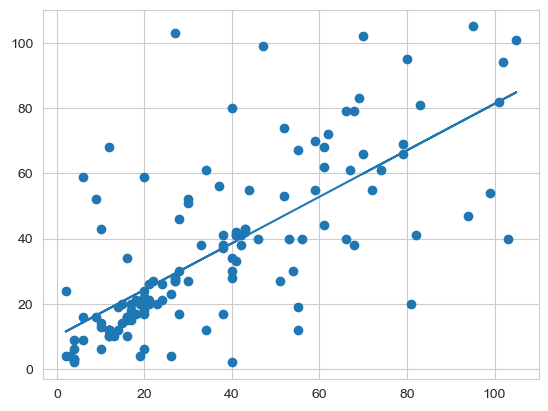

In [86]:
m, b = np.polyfit(pts[:-1], pts[1:],1)


plt.scatter(pts[:-1],pts[1:])

plt.plot(pts[:-1], m*pts[:-1]+b)

plt.show()

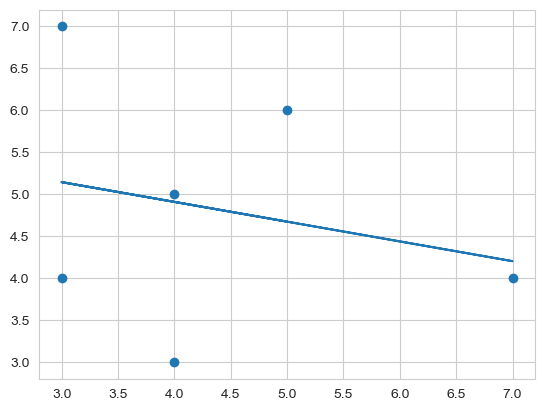

In [18]:
pts = np.array([3,4,3,7,4,5,6])

m, b = np.polyfit(pts[:6], pts[1:],1)


plt.scatter(pts[:6],pts[1:])

plt.plot(pts[:6], m*pts[:6]+b)

plt.show()
